<a href="https://colab.research.google.com/github/yoon0411/pdm22/blob/main/py_tensorflow/pdm22_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##transfer learning이란
= transfer learning을 전이학습이라고도 부르며, 높은 정확도를 빠른 시간 내에 달성할 수 있기 때문에 컴퓨터 비전 분야에서 유명한 방법 중 하나 입니다. 전이학습을 이용하면, 이미 학습한 문제와 다른 문제를 풀 때에도, 밑바닥에서부터 모델을 쌓아올리는 대신에 이미 학습되어있는 패턴들을 활용해서 적용시킬 수 있습니다. 컴퓨터 비전에서 말하는 전이학습은 주로 사전 학습된 모델을 이용하는 것을 뜻합니다. 사전학습 된 모델이란, 내가 풀고자 하는 문제와 비슷하면서 사이즈가 큰 데이터로 이미 학습이 되어 있는 모델입니다. 그런 큰 데이터로 모델을 학습시키는 것은 오랜 시간과 연산량이 필요하므로, 관례적으로는 이미 공개되어있는 모델들을 import해서 사용합니다.

In [21]:
from tensorflow.keras.applications.mobilenet_v2 import  MobileNetV2, preprocess_input
import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from keras.utils import np_utils
from keras.models import load_model
from keras.datasets import cifar10
from keras.preprocessing import image
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [22]:
tf.keras.backend.clear_session()  # For memory

# GPU check
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print("#### ", len(gpus), "Physical GPUs,",
                 len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print('#### No CUDA supported GPU in this computer.')

####  1 Physical GPUs, 1 Logical GPUs


In [25]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


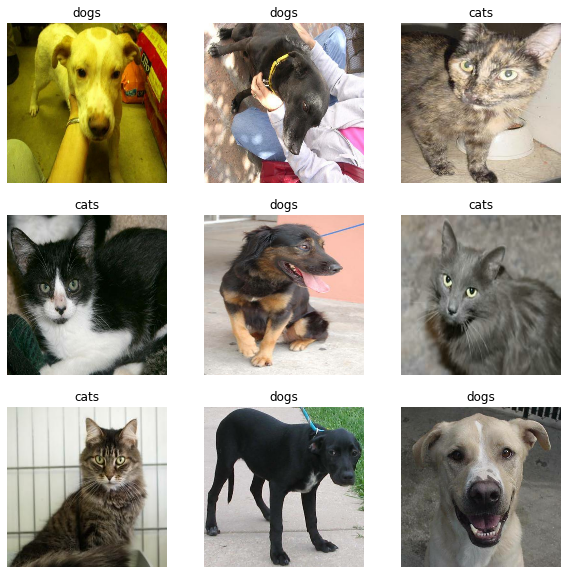

In [37]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [38]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

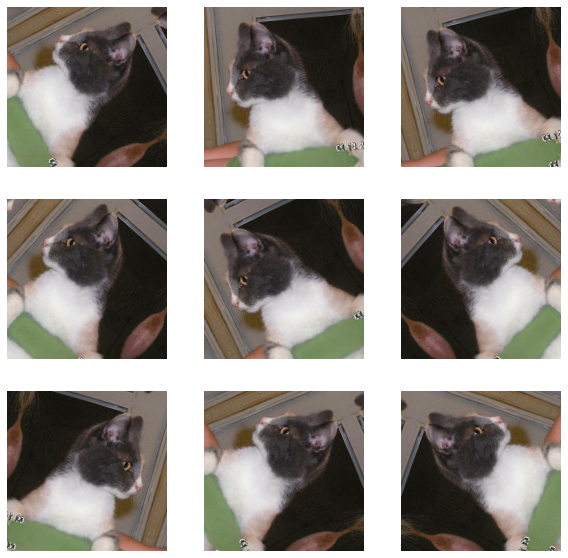

In [39]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [32]:
from keras.datasets import cifar10
# load dataset
(trainX, trainy), (testX, testy) = cifar10.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


In [33]:
TL_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [34]:
TL_base.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [40]:
def feature_extractor(inputs):

  TL_base = MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')
  #   Unfreeze top layers for fine tuning
  TL_base.trainable = False
  return TL_base(inputs)


'''
Defines final dense layers and subsequent softmax layer for classification.
'''
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

'''
Since input image size is (32 x 32), first upsample the image by factor of (7x7) to transform it to (224 x 224)
Connect the feature extraction and "classifier" layers to build the model.
'''
def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

'''
Define the model and compile it. 
Use Stochastic Gradient Descent as the optimizer.
Use Sparse Categorical CrossEntropy as the loss function.
'''
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
 
  model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',  # y_train is NOT one-hot encoded!
                metrics = ['accuracy'])
  
  return model


model = define_compile_model()

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                             

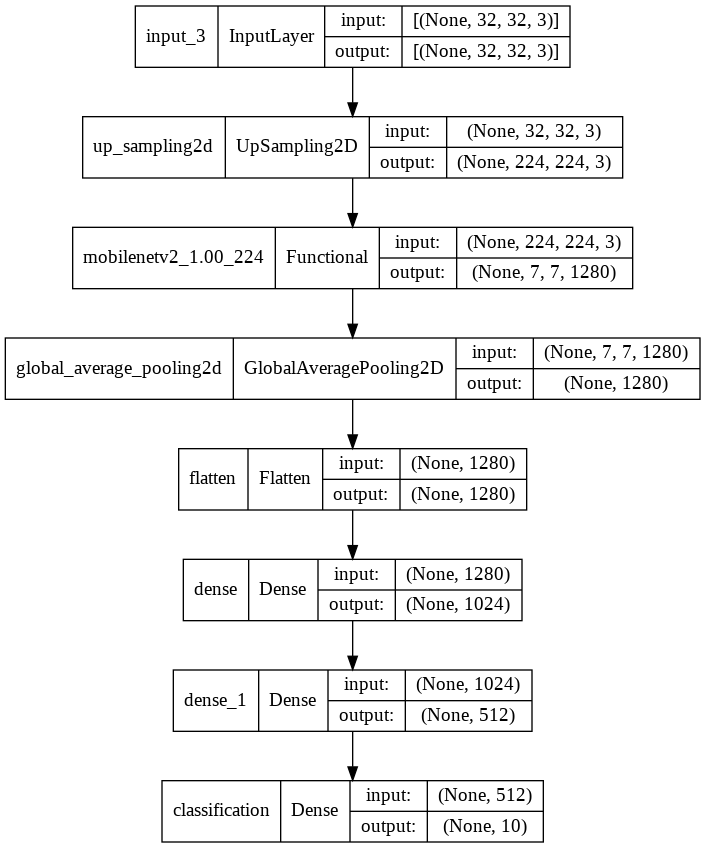

In [41]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model_F.png')

In [42]:
from tensorflow.keras import layers, models, callbacks
mc_callback = callbacks.ModelCheckpoint(filepath="./model/cifar10pct100_mobileNetV2F_SGD_best_weights.{epoch:03d}-{val_accuracy:.3f}.hdf5", 
                              monitor='val_accuracy', verbose=0, save_best_only=True)
es_callback = callbacks.EarlyStopping(monitor='val_accuracy', 
                            mode='max', verbose=1, patience=5)

In [43]:
from keras import backend
from keras.datasets import cifar10
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

In [44]:
tf.keras.backend.clear_session()  # For memory

In [45]:
def feature_extractor_fine_tuning(inputs):

  TL_base = MobileNetV2(input_shape=(224, 224, 3),
                            include_top=False,
                            weights='imagenet')
#   Unfreeze top layers for fine tuning
  TL_base.trainable = True
  # Fine-tune from this layer onwards
  fine_tune_at = 107

  # Freeze all the layers before the `fine_tune_at` layer
  for layer in TL_base.layers[:fine_tune_at]:
    layer.trainable =  False

  return TL_base(inputs)

def final_model_ft(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

    fine_feature_extractor = feature_extractor_fine_tuning(resize)
    classification_output = classifier(fine_feature_extractor)

    return classification_output

def define_compile_model_ft():
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model_ft(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
 
  model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',  # y_train is NOT one-hot encoded!
                metrics = ['accuracy'])
  
  return model

model = define_compile_model_ft()

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                             

In [46]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = preprocess_input(input_images)
  return output_ims
x_train = preprocess_image_input(trainX)
x_test = preprocess_image_input(testX)

In [47]:
y_train=trainy
y_test=testy
y_train.shape,y_test.shape

((50000, 1), (10000, 1))

In [48]:
from tensorflow.keras import layers, models, callbacks

In [49]:
mc_callback = callbacks.ModelCheckpoint(filepath="./model/cifar10_pct100_mobilenetV2S_SGD_best_weights.{epoch:03d}-{val_accuracy:.4f}.hdf5", 
                              monitor='val_accuracy', verbose=0, save_best_only=True)
es_callback = callbacks.EarlyStopping(monitor='val_accuracy', 
                            mode='max', verbose=1, patience=5)

In [ ]:

history = model.fit(x_train, y_train, 
                    epochs=50, batch_size=10, 
                    validation_data=(x_test, y_test),
                    callbacks=[mc_callback,es_callback])

Epoch 1/50
2615/5000 [==============>...............] - ETA: 1:46 - loss: 0.7590 - accuracy: 0.7413